In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
# 데이터 불러오기
dataset = pd.read_csv('/data.csv')

# 빈 값 확인 후 제거
dataset = dataset.dropna()

In [ ]:
# 년도와 월 추출
dataset['Year'] = dataset['Date'].apply(lambda x: int(x.split('-')[0]))
dataset['Month'] = dataset['Date'].apply(lambda x: int(x.split('-')[1]))
del dataset['Date']

# 필요한 특성만 선택
column_names = ['NDVIsample', 'longitude', 'latitude', 'Temp', 'Windspeed', 'Winddirection', 'Solar', 'Year', 'Month']
dataset = dataset[column_names + ['SST']]

# 데이터 분할
train_dataset = dataset.sample(frac=0.6, random_state=42)
temp_dataset = dataset.drop(train_dataset.index)
valid_dataset = temp_dataset.sample(frac=0.5, random_state=42)
test_dataset = temp_dataset.drop(valid_dataset.index)

# 라벨 분리
train_labels = train_dataset.pop('SST')
valid_labels = valid_dataset.pop('SST')
test_labels = test_dataset.pop('SST')

# 데이터 정규화
train_stats = train_dataset.describe().transpose()
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_valid_data = norm(valid_dataset)
normed_test_data = norm(test_dataset)

# 모델 구성
def build_model():
  model = keras.Sequential([
      layers.Dense(32, activation='relu', input_shape=[len(train_dataset.columns)]),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model
model = build_model()

# 모델 학습
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_data=(normed_valid_data, valid_labels), verbose=0, callbacks=[early_stop])

# 학습 과정 시각화
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure(figsize=(8,12))
  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [SST]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$SST^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

# 모델 평가
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Loss: ", loss)
print("MAE: ", mae)
print("MSE: ", mse)

# 예측
predictions = model.predict(normed_test_data).flatten()

# R^2 계산
r2 = r2_score(test_labels, predictions)
print("Test R^2: ", r2)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print("Test RMSE: ", rmse)

# 훈련 데이터에 대한 예측
train_predictions = model.predict(normed_train_data).flatten()

# 훈련 데이터에 대한 R^2 계산
train_r2 = r2_score(train_labels, train_predictions)
print("Train R^2: ", train_r2)

# 훈련 데이터에 대한 RMSE 계산
train_rmse = np.sqrt(mean_squared_error(train_labels, train_predictions))
print("Train RMSE: ", train_rmse)

878/878 - 1s - loss: 0.0520 - mae: 0.0480 - mse: 0.0520 - 1s/epoch - 1ms/step
Loss:  0.05202585458755493
MAE:  0.04798956587910652
MSE:  0.05202585458755493
878/878 [==============================] - 1s 2ms/step
Test R^2:  0.9837296579219623
Test RMSE:  0.22809184007185726
2632/2632 [==============================] - 5s 2ms/step
Train R^2:  0.9929308593093903
Train RMSE:  0.14965706293978748


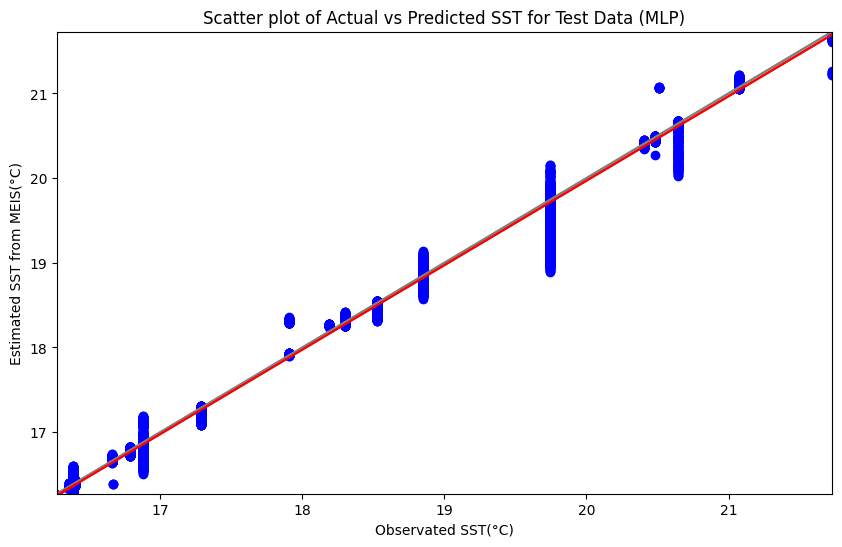

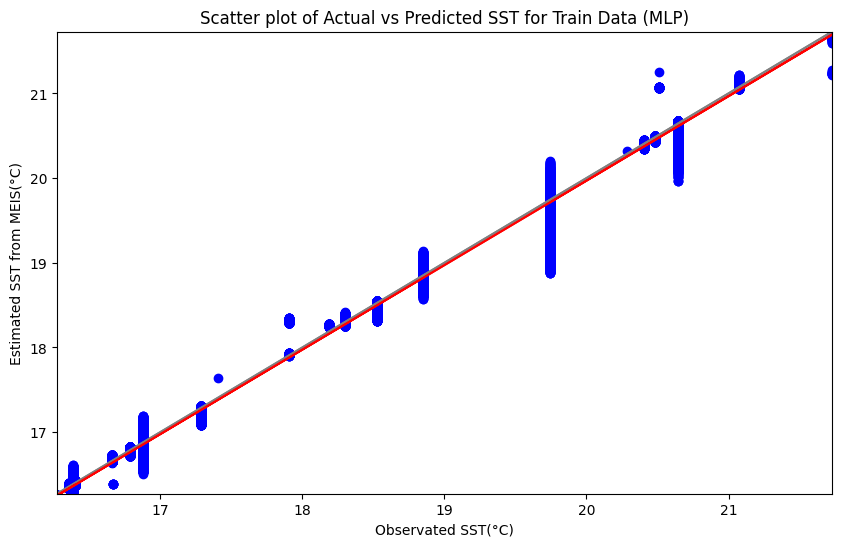

In [ ]:
import matplotlib.pyplot as plt

# 테스트 데이터에 대한 산포도
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, c='blue')  # 파란색 점으로 실제값과 예측값의 관계를 표현
plt.xlabel('Observated SST(°C)')
plt.ylabel('Estimated SST from MEIS(°C)')
plt.title('Scatter plot of Actual vs Predicted SST for Test Data (MLP)')

# 회색선으로 기준선을 표현
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='gray')

# 빨간선으로 회귀선을 표현
m, b = np.polyfit(test_labels, predictions, 1)  # 1차 회귀분석으로 기울기와 절편을 구함
plt.plot(test_labels, m*test_labels + b, color='red')

# 동일한 범위로 x축과 y축 설정
plt.xlim([test_labels.min(), test_labels.max()])
plt.ylim([test_labels.min(), test_labels.max()])

plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='gray')

m, b = np.polyfit(test_labels, predictions, 1)
plt.plot(test_labels, m*test_labels + b, color='red')

plt.show()

# 훈련 데이터에 대한 산포도
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, train_predictions, c='blue')  # 파란색 점으로 실제값과 예측값의 관계를 표현
plt.xlabel('Observated SST(°C)')
plt.ylabel('Estimated SST from MEIS(°C)')
plt.title('Scatter plot of Actual vs Predicted SST for Train Data (MLP)')

# 회색선으로 기준선을 표현
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], color='gray')

# 빨간선으로 회귀선을 표현
m, b = np.polyfit(train_labels, train_predictions, 1)  # 1차 회귀분석으로 기울기와 절편을 구함
plt.plot(train_labels, m*train_labels + b, color='red')

# 동일한 범위로 x축과 y축 설정
plt.xlim([test_labels.min(), test_labels.max()])
plt.ylim([test_labels.min(), test_labels.max()])

plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='gray')

m, b = np.polyfit(test_labels, predictions, 1)
plt.plot(test_labels, m*test_labels + b, color='red')

plt.show()

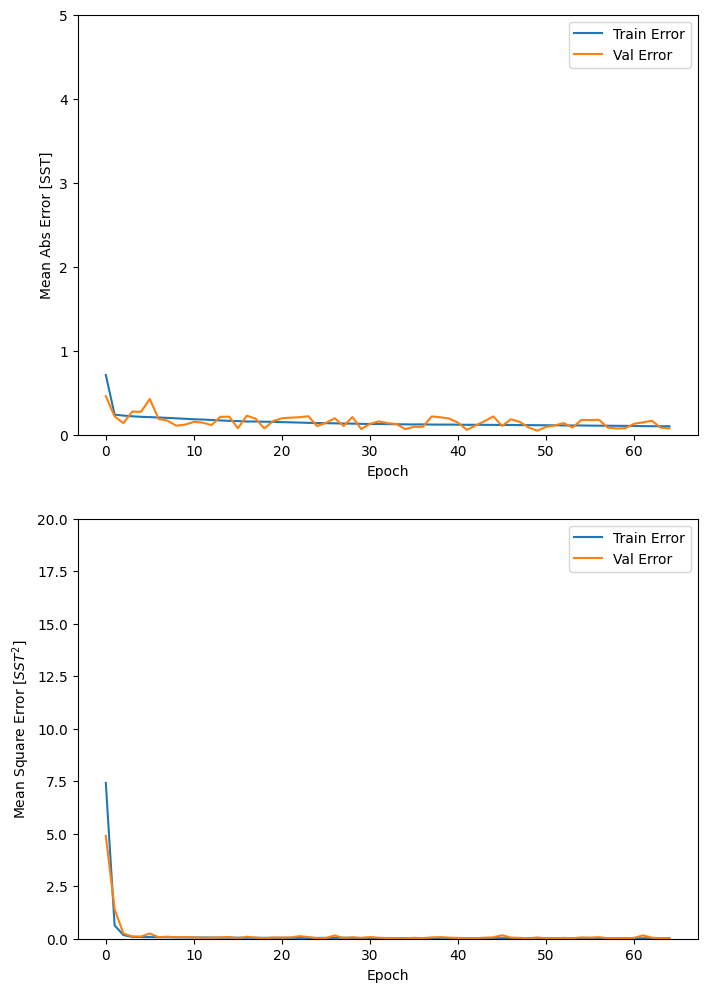

In [ ]:
plot_history(history)

In [ ]:
# 년도와 월 추출
dataset['Year'] = dataset['Date'].apply(lambda x: int(x.split('-')[0]))
dataset['Month'] = dataset['Date'].apply(lambda x: int(x.split('-')[1]))
del dataset['Date']

# 필요한 특성만 선택
column_names = ['NDVIsample', 'longitude', 'latitude', 'Temp', 'Windspeed', 'Winddirection', 'Solar', 'Year', 'Month', 'SST']
dataset = dataset[column_names + ['Chl']]

# 데이터 분할
train_dataset = dataset.sample(frac=0.6, random_state=42)
temp_dataset = dataset.drop(train_dataset.index)
valid_dataset = temp_dataset.sample(frac=0.5, random_state=42)
test_dataset = temp_dataset.drop(valid_dataset.index)

# 라벨 분리
train_labels = train_dataset.pop('Chl')
valid_labels = valid_dataset.pop('Chl')
test_labels = test_dataset.pop('Chl')

# 데이터 정규화
train_stats = train_dataset.describe().transpose()
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_valid_data = norm(valid_dataset)
normed_test_data = norm(test_dataset)

# 모델 구성
def build_model():
  model = keras.Sequential([
      layers.Dense(32, activation='relu', input_shape=[len(train_dataset.columns)]),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model
model = build_model()

# 모델 학습
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_data=(normed_valid_data, valid_labels), verbose=0, callbacks=[early_stop])

# 학습 과정 시각화
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure(figsize=(8,12))
  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Chl]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Chl^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

# 모델 평가
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Loss: ", loss)
print("MAE: ", mae)
print("MSE: ", mse)

# 예측
predictions = model.predict(normed_test_data).flatten()

# R^2 계산
r2 = r2_score(test_labels, predictions)
print("Test R^2: ", r2)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print("Test RMSE: ", rmse)

# 훈련 데이터에 대한 예측
train_predictions = model.predict(normed_train_data).flatten()

# 훈련 데이터에 대한 R^2 계산
train_r2 = r2_score(train_labels, train_predictions)
print("Train R^2: ", train_r2)

# 훈련 데이터에 대한 RMSE 계산
train_rmse = np.sqrt(mean_squared_error(train_labels, train_predictions))
print("Train RMSE: ", train_rmse)

878/878 - 1s - loss: 0.0014 - mae: 0.0088 - mse: 0.0014 - 1s/epoch - 1ms/step
Loss:  0.0013940116623416543
MAE:  0.008807058446109295
MSE:  0.0013940116623416543
878/878 [==============================] - 1s 1ms/step
Test R^2:  0.9987760823222378
Test RMSE:  0.0373364652350718
2632/2632 [==============================] - 4s 1ms/step
Train R^2:  0.9997065964863089
Train RMSE:  0.01840164092408204


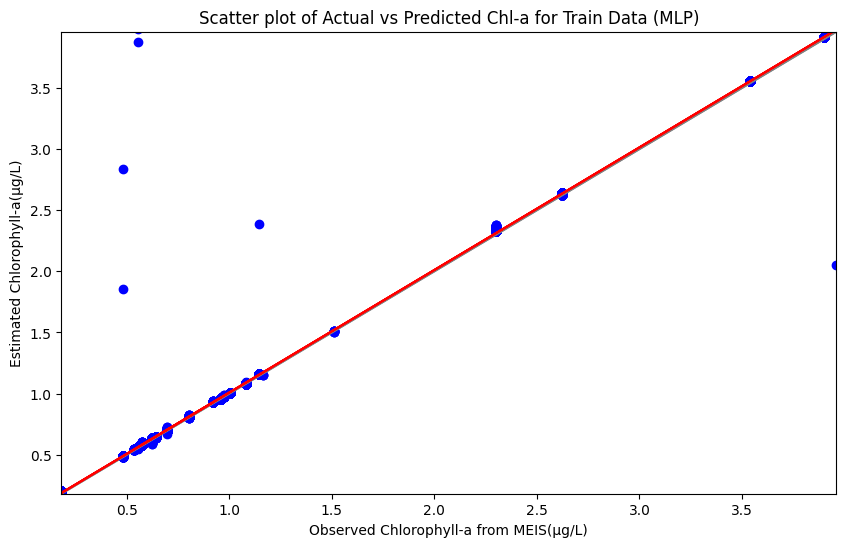

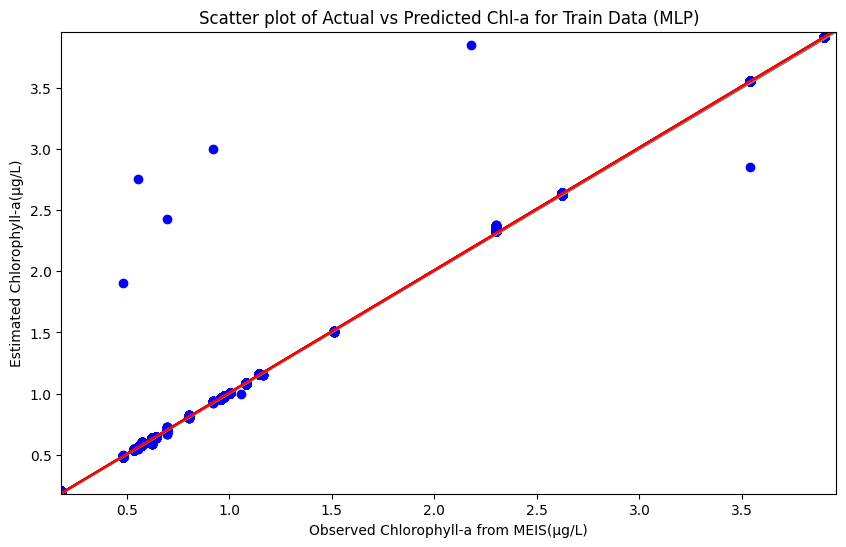

In [ ]:
import matplotlib.pyplot as plt

# 테스트 데이터에 대한 산포도
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, c='blue')  # 파란색 점으로 실제값과 예측값의 관계를 표현
plt.xlabel('Observed Chlorophyll-a from MEIS(μg/L)')
plt.ylabel('Estimated Chlorophyll-a(μg/L)')
plt.title('Scatter plot of Actual vs Predicted Chl-a for Train Data (MLP)')

# 회색선으로 기준선을 표현
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='gray')

# 빨간선으로 회귀선을 표현
m, b = np.polyfit(test_labels, predictions, 1)  # 1차 회귀분석으로 기울기와 절편을 구함
plt.plot(test_labels, m*test_labels + b, color='red')

# 동일한 범위로 x축과 y축 설정
plt.xlim([test_labels.min(), test_labels.max()])
plt.ylim([test_labels.min(), test_labels.max()])

plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='gray')

m, b = np.polyfit(test_labels, predictions, 1)
plt.plot(test_labels, m*test_labels + b, color='red')

plt.show()

# 훈련 데이터에 대한 산포도
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, train_predictions, c='blue')  # 파란색 점으로 실제값과 예측값의 관계를 표현
plt.xlabel('Observed Chlorophyll-a from MEIS(μg/L)')
plt.ylabel('Estimated Chlorophyll-a(μg/L)')
plt.title('Scatter plot of Actual vs Predicted Chl-a for Train Data (MLP)')

# 회색선으로 기준선을 표현
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], color='gray')

# 빨간선으로 회귀선을 표현
m, b = np.polyfit(train_labels, train_predictions, 1)  # 1차 회귀분석으로 기울기와 절편을 구함
plt.plot(train_labels, m*train_labels + b, color='red')

# 동일한 범위로 x축과 y축 설정
plt.xlim([test_labels.min(), test_labels.max()])
plt.ylim([test_labels.min(), test_labels.max()])

plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='gray')

m, b = np.polyfit(test_labels, predictions, 1)
plt.plot(test_labels, m*test_labels + b, color='red')

plt.show()

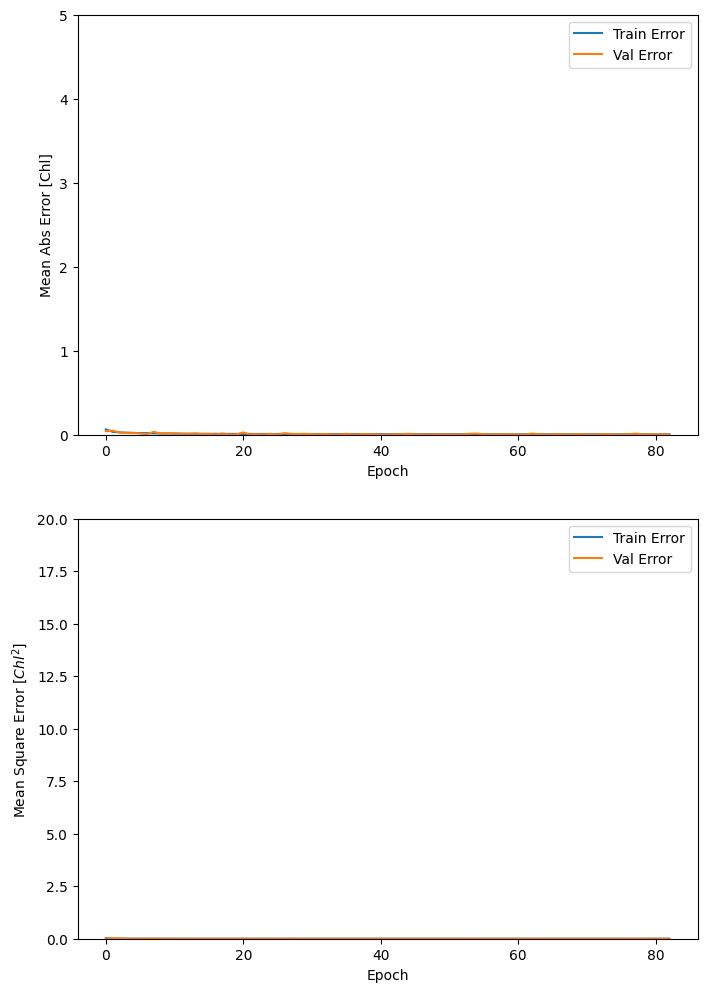

In [ ]:
plot_history(history)